# How to play a multi-armed bandit
_A classic problem that I discovered in chapter 2 of Sutton and Barto \[0]. There, the authors discuss various strategies before finally mentioning the technique of 'Gittins indices' for computing the optimal solution. They don't mention the technique again, presumably because it doesn't generalize to more general reinforcement learning problems. Here I compare the optimal solution to another strategy mentioned in the chapter: the $\varepsilon$-greedy strategy._
Date: 2017-04-06

#### The setup
<img src="bandit.jpg" alt="bandit machine" style="width: 200px; display:block ; margin: 0 auto">

Suppose that you have at hand a bank of ten one-arm bandits, each with an unknown mean payout. At each timestep, you are offered the opportunity to pull the arm of one of the bandits, and you receive a payout. How should you choose which are to pull at each timestep?

That's the classical formulation of the problem, although it might be more fitting instead to think of having an array of projects that you can invest time in (with an unknown) reward, rather than to consider bandits, which have negative means.

Here we'll assume that, for each arm, a value has been drawn from a $N(0,\sigma^2)$ distribution. The reward is the arm value plus $N(0, 1)$ noise. We maximize
$$\mathbb{E}\left[\sum_{t=0}^\infty\rho^tR_t\right],$$
for some parameter $\rho$ between 0 and 1, where $R_t$ denotes the reward on the $t$th timestep.

Stop for a moment and think of strategy you might use.

#### References
* \[0] Reinforcement Learning: An Introduction by Andrew Barto and Richard S. Sutton 1998
* \[1] Multi-Armed Bandit Allocation Indices by John Gittins, Kevin Glazebrook and Richard Weber 2011

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import seaborn as sns
%matplotlib inline

## The setup

We'll simulate the performance of two different kinds of strategies: first the $\epsilon$-greedy method and then we'll see the optimal solution using Gittins indices. We'll approximate the infinite horizon reward by simulating a large finite number of rounds.

This is the same setup as in Sutton & Barto.

Let $\mu$, the value of each arm, have law $N(0, \sigma^2)$. Let $\epsilon$, the noise in arm payouts, have law $N(0, 1)$. Then the reward is $R=\mu+\epsilon.$

In [2]:
num_rounds = 1000 # The number of rounds to simulate
num_arms = 10 # The number of bandits
num_samples = 2000 # The number of times to run the simulation
rho = 1 - 1 / 1000. # The discount factor
sigma = 1. # The variance of the mean of each arm

Draw the arm means, $\mu$, for each of the simulations, together with the reward noise.

In [3]:
np.random.seed(0)
arm_means = np.random.randn(num_samples, num_arms)
noise = np.random.randn(num_samples, num_rounds)

These dicts will store the results, keyed by the name of the strategy.

In [4]:
arm_choices = {}
rewards = {}

### The $\varepsilon$-greedy strategy  

This strategy pulls the arm with the best mean reward observed so far with probability $1-\varepsilon$ and chooses an arm at random with probability $\varepsilon$, for some fixed $\varepsilon$.

In [5]:
def run_eps_greedy_sample(eps, sample_num):
    pull_counts = np.zeros(num_arms, dtype=int)
    total_rewards = np.zeros(num_arms)
    sample_arm_choices = np.zeros(num_rounds, dtype=int)
    rewards = np.zeros(num_rounds)
    
    np.seterr(divide='ignore', invalid='ignore')
    for r in range(num_rounds):
        if np.random.random() < eps:
            # Choose random arm.
            sample_arm_choices[r] = np.random.randint(0, num_arms)
        else:
            # Choose the arm with the greatest mean return.
            arm_mean_est = total_rewards / pull_counts
            arm_mean_est[np.isnan(arm_mean_est)] = 0.
            sample_arm_choices[r] = np.argmax(arm_mean_est)
        
        rewards[r] = arm_means[sample_num, sample_arm_choices[r]] \
            + noise[sample_num, r]
        total_rewards[sample_arm_choices[r]] += rewards[r]
        pull_counts[sample_arm_choices[r]] += 1
    return sample_arm_choices, rewards   

def run_eps_greedy(eps):
    strategy_arm_choices = np.zeros((num_samples, num_rounds))
    strategy_rewards = np.zeros((num_samples, num_rounds))
    for sample_num in range(num_samples):
        strategy_arm_choices[sample_num], strategy_rewards[sample_num] = \
            run_eps_greedy_sample(eps, sample_num)
    
    strategy_name = 'eps_greedy_{}'.format(eps)
    arm_choices[strategy_name], rewards[strategy_name] = \
        strategy_arm_choices, strategy_rewards

Run simulations with $\varepsilon=0.01$ and $\varepsilon=0.1$.

In [6]:
# Load a vectorized version of `run_eps_greedy`.
%run -i eps_greedy_vectorized.py
for eps in [0.1, 0.01]:
    run_eps_greedy_vectorized(eps)

This function shows the results obtained so far.

In [7]:
best_arms = arm_means.argmax(1)
def show_results():
    fig, (ax_top, ax_bottom) = plt.subplots(nrows=2, sharex=True, figsize=(8, 8))
    
    for strategy_name, _rewards in rewards.items():
        discounted_rewards = _rewards * (rho ** np.arange(num_rounds))
        mean_cum_rewards = discounted_rewards.cumsum(1).mean(0)
        ax_top.plot(mean_cum_rewards, label=strategy_name)
    for strategy_name, _arm_choices in arm_choices.items():
        prop_best = (best_arms[:, np.newaxis] == _arm_choices).mean(0)
        ax_bottom.plot(prop_best, label=strategy_name)
    
    ax_top.set_ylabel('Mean cumulative discounted reward')
    ax_top.set_ylim(bottom=0)
    ax_bottom.set_xlabel('Number of rounds')
    ax_bottom.set_ylabel('Proportion choosing optimal arm')
    ax_bottom.set_ylim(0, 1)
    ax_bottom.set_xlim(0, num_rounds)
    ax_bottom.legend(loc='lower right')
    fig.tight_layout()

Show the results for the $\varepsilon$-greedy strategies.

In [8]:
show_results()

Ok, so the total discounted reward of the better $\varepsilon$-greedy strategy (with $\varepsilon=0.1$) is just above 800. How much better will the optimal strategy be?

## The optimal strategy

The optimal strategy may be obtained by computing the Gittins Index for each arm and at each step choosing the arm with the largest index value. That there is such as index is the content of the Gittins Index Theorem.

### The Gittins Index Theorem

This theorem states that there is a way of assigning a score 'index value' to each arm, dependent only on its state, such that the optimal policy is the policy that chooses an arm with the greatest score at each timestep. This index value is known as the Gittins index. The theorem is remarkable because it reduces a high-dimensional Bayesian control problem into one where the arms can be considered individually.

### Computing the value of a fixed alternative

Consider the bandit problem with two arms: one provides a reward $p$ on each timestep and the other provides a Gaussian-distributed reward with mean $\hat{\mu}$ and variance $\sigma^2$. The optimal strategy is to choose the random arm until some stopping time $\tau$ and the constant arm thereafter. Let $$V(\hat{\mu}, \sigma^2, p) = \sup_\tau\mathbb{E}_\tau\left[\sum_{t=0}^\infty\rho^tR_t\right]$$
$$R_t=\begin{cases}X_t\quad \text{if}\quad t < \tau \\p\quad\text{otherwise} \end{cases}$$
$$X_t \sim N(\mu, 1)$$
$$\mu \sim N(\hat{\mu}, \sigma ^ 2)$$
$$V(\hat{\mu}, \sigma^2, p) = \frac{p}{1 - \rho} + V(\hat{\mu} - p, \sigma^2, 0) \equiv p + U(\hat{\mu} -p, \sigma ^ 2)$$

So it suffices to compute $V$ under the assumption of zero alternative payout.

### The Bayesian update



The posterior distribution of $\mu$ is
$$N\left(\frac{r\sigma ^ 2 + \hat{\mu}}{\sigma ^ 2 + 1}, \frac{\sigma ^ 2}{\sigma ^ 2 + 1}\right)$$

The distribution of the posterior mean is
$$N\left(\hat{\mu}, \sigma ^ 2\left[\frac{\sigma ^ 2}{\sigma ^ 2 + 1}\right]\right)$$

In [9]:
num_means = 2 ** 14
max_pulls = 2 ** 10
max_abs_mean = 12.
means = np.linspace(-max_abs_mean, max_abs_mean, num_means)

In [10]:
value_fn = np.zeros((max_pulls, num_means)) # mean, npulls
value_fn[-1] = np.maximum(means, 0) / (1 - rho)
sigmas = sigma / np.sqrt(1 + np.arange(max_pulls))
for t in reversed(range(max_pulls - 1)):
    posterior_mean_var = sigmas[t] ** 2 * (sigmas[t] ** 2 / (sigmas[t] ** 2 + 1) ** 2)
    interpolation = scipy.interpolate.interp1d(
        means, value_fn[t + 1], fill_value='extrapolate')
    posterior_mean_std = np.sqrt(posterior_mean_var)
    nsv = (interpolation(means + posterior_mean_std) \
        + interpolation(means - posterior_mean_std)) / 2.
    continuation_val = means + rho * nsv
    value_fn[t] = np.maximum(np.maximum(continuation_val, 0), value_fn[t + 1])

### Computing the Gittins Index

We now compute the Gittins Index for an arm whose payout is Gaussian with the given mean and variance. The Gittins Index is increasing in the mean and the variance.

In [11]:
critical_vals = []
for t in range(max_pulls):
    zeros = np.where(value_fn[t] == 0.)[0]
    if len(zeros):
        idx = zeros[-1]
    else:
        idx = 0
    critical_val = means[idx]
    critical_vals.append(critical_val)

plt.plot(range(max_pulls), critical_vals);

$$g(\hat{\mu}, \sigma^2) = \sup_{p}: V(\hat{\mu}, \sigma^2, p) = p / (1-\rho)$$ 
$$U(\hat{\mu} - p, \sigma^2) + p / (1 - \rho) = p / (1-\rho)$$
$$U(\hat{\mu} - p, \sigma^2)= 0$$

In [12]:
def calc_gittins_idx(mean, npulls):
    return mean - critical_vals[npulls]

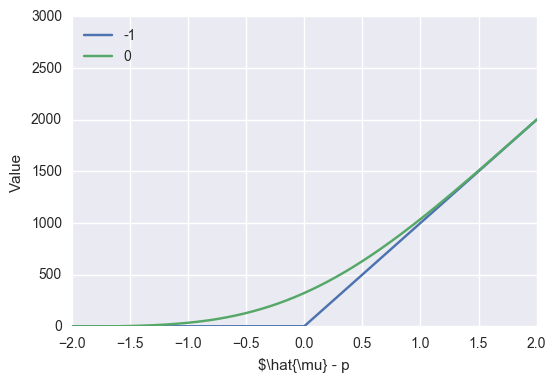

In [14]:
def plot_value_slice(n):
    plt.plot(means, value_fn[n], label=str(n))
    plt.xlim(-2, 2)
    plt.ylim(0, 3000)
plot_value_slice(-1)
plot_value_slice(0)
plt.xlabel('$\hat{\mu} - p')
plt.ylabel('Value')
plt.legend(loc='upper left');

### The optimal algorithm

In [15]:
def run_optimal_single(sample_means, sample_noise):
    muhat = np.zeros(num_arms)
    npulls = np.zeros(num_arms, dtype=int)
    gittins_indices = np.zeros(num_arms) * np.NaN
    arm_choices = []
    rewards = np.zeros(num_rounds)
    
    for r in range(num_rounds):
        for arm in range(num_arms):
            gittins_indices[arm] = calc_gittins_idx(muhat[arm], npulls[arm])
        arm_to_pull = np.argmax(gittins_indices)
        sigma_sq = 1 / (1 + npulls[arm_to_pull])
        npulls[arm_to_pull] += 1
        rewards[r] = sample_means[arm_to_pull] + sample_noise[r]
        muhat[arm_to_pull] = (sigma_sq * rewards[r] + muhat[arm_to_pull]) / (sigma_sq + 1)
        arm_choices.append(arm_to_pull)
    assert len(arm_choices) == num_rounds
    return np.array(arm_choices), rewards

In [16]:
_arm_choices = np.zeros((num_samples, num_rounds)) * np.NaN
gittins_rewards = np.zeros((num_samples, num_rounds))
for sample_num in range(num_samples):
    _arm_choices[sample_num], gittins_rewards[sample_num] = \
        run_optimal_single(arm_means[sample_num], noise[sample_num])
rewards['gittins_index'] = gittins_rewards
arm_choices['gittins_index'] = _arm_choices

### Performance comparison

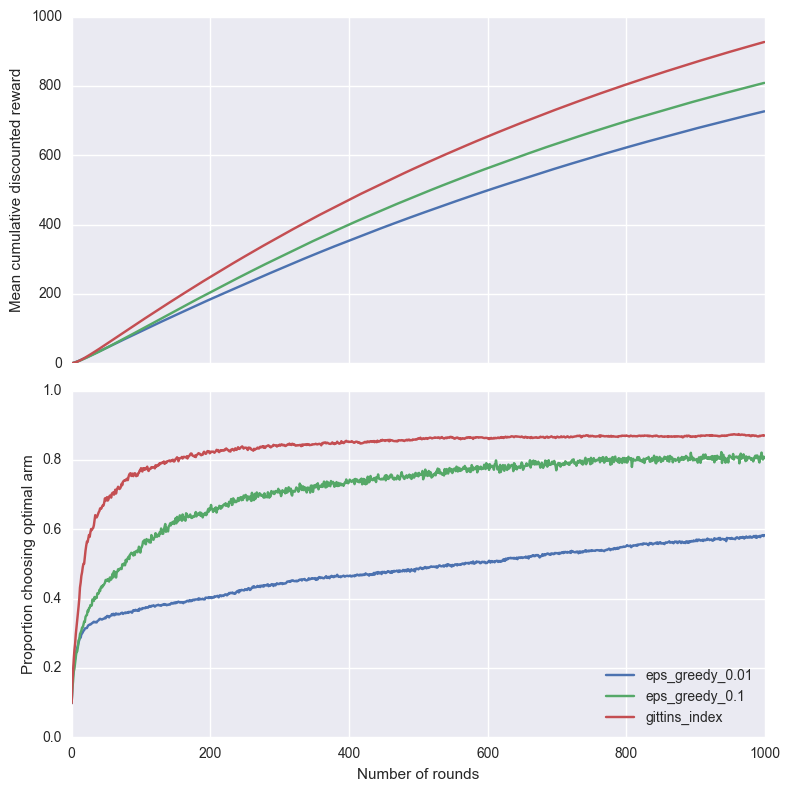

In [17]:
 show_results()

As expected, the Gittins Index policy performs better than the $\varepsilon$-greedy strategies.